# Load Package and Data

In [2]:
import pandas as pd
import numpy as np
from matplotlib.path import Path
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import norm, linregress
from scipy.special import erf
from scipy.optimize import minimize

In [3]:
n = 1000 # jumlah titik acak
m = 10  # jumlah pengulangan simulasi

batas = pd.read_csv('../Data/Lat Long M7.csv')

R = 6371 # Radius of the Earth in kilometers

data = pd.read_csv('../Data/M7 Declustering.csv')
u = 5.65
e = 0.00001

# Location

In [4]:
boundaries = batas[['longitude', 'latitude']].values
polygon_path = Path(boundaries)

def is_inside(point, path):
    return path.contains_point(point)

def monte_carlo_polygon(boundaries, num_points, path):
    min_x, min_y = np.min(boundaries, axis=0)
    max_x, max_y = np.max(boundaries, axis=0)
    points = []
    while len(points) < num_points:
        x = np.random.uniform(min_x, max_x)
        y = np.random.uniform(min_y, max_y)
        if is_inside((x, y), path):
            points.append((x, y))
    return np.array(points)

simulasi = monte_carlo_polygon(boundaries, n, polygon_path)

# Simpan ke DataFrame
simulasi = pd.DataFrame(simulasi, columns=['Longitude', 'Latitude'])
print(simulasi.head())

# Plot hasil simulasi di peta dengan scatter_mapbox
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik Uniform dalam Poligon Batas",
    mapbox_style="open-street-map"
)

# Tambahkan outline poligon batas area
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)

fig.show()

    Longitude  Latitude
0  104.715263 -6.750416
1  106.839211 -7.726504
2  106.260560 -8.081519
3  104.514332 -7.691937
4  105.845325 -7.515990


# Kedalaman

Fungsi-fungsi yang dipakai

In [5]:
from math import radians, cos, sin, asin, sqrt, atan, tan, degrees

In [6]:
def longlat_to_xyz(lon, lat, R=6371):
    lon, lat = radians(lon), radians(lat)
    x = R * cos(lat) * cos(lon)
    y = R * cos(lat) * sin(lon)
    z = R * sin(lat)
    return x, y, z

def project_point_to_line(p, a, b):
    a, b, p = np.array(a), np.array(b), np.array(p)
    d = b - a  # Vektor arah garis ab
    ap = p - a  # Vektor dari a ke p
    proj_ap_onto_d = (np.dot(ap, d) / np.dot(d, d)) * d  # Proyeksi ap ke d
    q = a + proj_ap_onto_d  # Titik hasil proyeksi di garis ab
    return q

def xyz_to_longlat(x, y, z, R=6371):
    lat = np.degrees(np.arcsin(z / R))
    lon = np.degrees(np.arctan2(y, x))
    return lon, lat

def haversine(lat1, lon1, lat2, lon2):
    dlat = radians(lat2)-radians(lat1)
    dlon = radians(lon2)-radians(lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c  # Jarak dalam km

Derajat trigonometri

Jarak antara (103.95, -7.68) dan (104.78, -6.28) adalah: 180.63 km
Jarak antara (107.15, -7.30) dan (106.45, -9.08) adalah: 212.39 km
Rata-rata jarak = 196.51 km
Besar derajatnya adalah 16.98 derajat


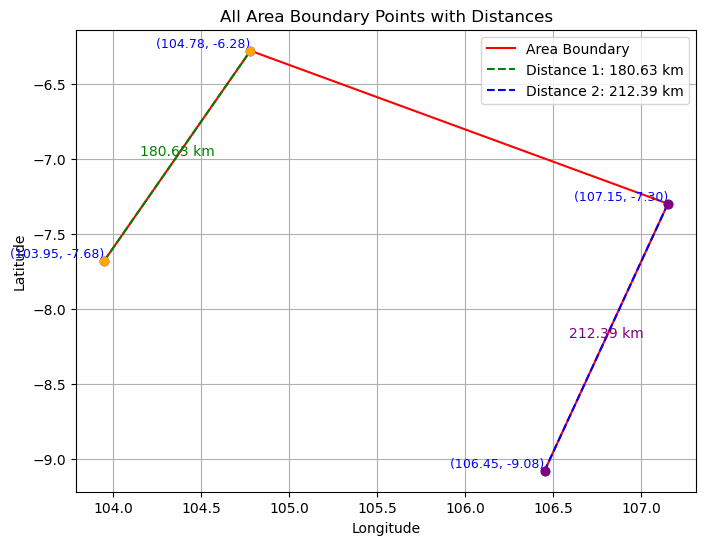

In [7]:
# Pastikan data cukup
if len(batas) < 4:
    raise ValueError("Data batas kurang dari 4 baris, tidak bisa menghitung dua pasang jarak.")

# Ambil empat titik pertama dari data batas
lon1, lat1 = batas.iloc[0][['longitude', 'latitude']]
lon2, lat2 = batas.iloc[1][['longitude', 'latitude']]
lon3, lat3 = batas.iloc[2][['longitude', 'latitude']]
lon4, lat4 = batas.iloc[3][['longitude', 'latitude']]

# Hitung jarak antar pasangan titik
jarak1 = haversine(lat1, lon1, lat2, lon2)
jarak2 = haversine(lat3, lon3, lat4, lon4)
rata_jarak = (jarak1 + jarak2) / 2

print(f"Jarak antara ({lon1:.2f}, {lat1:.2f}) dan ({lon2:.2f}, {lat2:.2f}) adalah: {jarak1:.2f} km")
print(f"Jarak antara ({lon3:.2f}, {lat3:.2f}) dan ({lon4:.2f}, {lat4:.2f}) adalah: {jarak2:.2f} km")
print(f"Rata-rata jarak = {rata_jarak:.2f} km")

# Hitung theta (misal ingin membandingkan dengan lebar 60 km)
theta = atan(60 / rata_jarak)
print(f"Besar derajatnya adalah {degrees(theta):.2f} derajat")

# Plot semua titik batas dan beri nama (long, lat)
plt.figure(figsize=(8, 6))
plt.plot(batas['longitude'], batas['latitude'], 'r-', label='Area Boundary')
plt.scatter(batas['longitude'], batas['latitude'], color='blue', zorder=5)

# Tulis nama semua titik (long, lat)
for i, row in batas.iterrows():
    plt.text(row['longitude'], row['latitude'], f"({row['longitude']:.2f}, {row['latitude']:.2f})", 
             fontsize=9, ha='right', va='bottom', color='blue')

# Tandai dan beri label jarak pada pasangan titik
plt.scatter([lon1, lon2], [lat1, lat2], color='orange', zorder=6)
plt.plot([lon1, lon2], [lat1, lat2], 'g--', label=f'Distance 1: {jarak1:.2f} km')
plt.text((lon1+lon2)/2, (lat1+lat2)/2, f"{jarak1:.2f} km", color='green', fontsize=10, ha='center')

plt.scatter([lon3, lon4], [lat3, lat4], color='purple', zorder=6)
plt.plot([lon3, lon4], [lat3, lat4], 'b--', label=f'Distance 2: {jarak2:.2f} km')
plt.text((lon3+lon4)/2, (lat3+lat4)/2, f"{jarak2:.2f} km", color='purple', fontsize=10, ha='center')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('All Area Boundary Points with Distances')
plt.legend()
plt.grid(True)
plt.show()

Menghitung kedalaman

In [8]:
# Ambil titik ke-1 dan ke-4 dari DataFrame batas
boundaries = batas.iloc[[0, 3]][['longitude', 'latitude']].values
print(boundaries)

# Konversi dan proyeksi langsung
simulasi[['x', 'y', 'z']] = simulasi.apply(lambda row: pd.Series(longlat_to_xyz(row['Longitude'], row['Latitude'])), axis=1)
bound = pd.DataFrame(boundaries, columns=['longitude', 'latitude'])
bound[['x', 'y', 'z']] = bound.apply(lambda row: pd.Series(longlat_to_xyz(row['longitude'], row['latitude'])), axis=1)

# Proyeksi ke satu garis saja (dari titik ke-2 ke titik ke-3)
a, b = bound.iloc[0][['x', 'y', 'z']].values, bound.iloc[1][['x', 'y', 'z']].values
q_points = simulasi.apply(lambda row: project_point_to_line(row[['x', 'y', 'z']].values, a, b), axis=1)
q_longlats = pd.DataFrame([xyz_to_longlat(*q) for q in q_points], columns=['q_lon', 'q_lat'])

simulasi[['q_lon', 'q_lat']] = q_longlats

# Hitung jarak dan kedalaman
simulasi['Jarak_epi'] = simulasi.apply(lambda row: haversine(row['Latitude'], row['Longitude'], row['q_lat'], row['q_lon']), axis=1)
simulasi['Jarak'] = 2 * R * np.sin(simulasi['Jarak_epi'] / (2 * R))
simulasi['Kedalaman (km)'] = simulasi['Jarak'] * np.tan(theta)

# Hapus kolom yang tidak diperlukan
columns_to_drop = ['x', 'y', 'z', 'q_lon', 'q_lat']
simulasi.drop(columns=columns_to_drop, inplace=True)

print(simulasi.head())

# Scatter mapbox dengan warna berdasarkan kedalaman
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    color="Kedalaman (km)",
    color_continuous_scale="Viridis",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik & Kedalaman (warna = kedalaman)",
    mapbox_style="open-street-map"
)

# Tambahkan outline poligon batas area
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)

# Atur posisi legend agar tidak tabrakan
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()

[[103.95  -7.68]
 [106.45  -9.08]]
    Longitude  Latitude   Jarak_epi       Jarak  Kedalaman (km)
0  104.715263 -6.750416  131.527687  131.525352       40.158670
1  106.839211 -7.726504  152.092553  152.088941       46.437357
2  106.260560 -8.081519   86.391374   86.390712       26.377699
3  104.514332 -7.691937   29.476230   29.476203        8.999977
4  105.845325 -7.515990  118.666463  118.664748       36.231939


# Magnitudo

## Lognormal-GPD

In [9]:
def log_likelihood_lognormal_gpd(params, data, u):
    mu, sigma_logn, xi, sigma_gpd = params
    if sigma_logn <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Lognormal part
    z = (np.log(below_u) - mu) / sigma_logn
    ll_logn = np.sum(-np.log(below_u * sigma_logn * np.sqrt(2 * np.pi)) - 0.5 * z**2)
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - norm.cdf((np.log(u) - mu) / sigma_logn)) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - norm.cdf((np.log(u) - mu) / sigma_logn)) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_logn + ll_gpd)  # negative for minimization

def estimate_lognormal_gpd(data, u):
    mu0 = np.mean(np.log(data[data < u]))
    sigma_logn0 = np.std(np.log(data[data < u]))
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (None, None),      # mu
        (1e-6, None),      # sigma_logn
        (-1, 1),           # xi
        (1e-6, None)       # sigma_gpd
    ]
    
    result = minimize(
        log_likelihood_lognormal_gpd,
        x0=[mu0, sigma_logn0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    mu, sigma_logn, xi, sigma_gpd = result.x
    print("Estimasi Parameter Lognormal-GPD")
    print("Parameter Lognormal:")
    print(f"\\mu (lokasi) = {mu:.4f}")
    print(f"\\sigma (skala) = {sigma_logn:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return mu, sigma_logn, xi, sigma_gpd

def logn_comp_cdf(x, mu, sigma_logn, xi, sigma_gpd, u):
    # CDF komposit lognormal-GPD
    cdf_logn = norm.cdf((np.log(np.minimum(x, u)) - mu) / sigma_logn)
    if np.isscalar(x):
        if x < u:
            return cdf_logn
        else:
            if xi != 0:
                cdf_gpd = 1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf = np.where(
            x < u,
            cdf_logn,
            np.where(
                xi != 0,
                1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

In [10]:
mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd = estimate_lognormal_gpd(data['mag'].values, u)

Estimasi Parameter Lognormal-GPD
Parameter Lognormal:
\mu (lokasi) = 1.5829
\sigma (skala) = 0.0906
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.1724
\sigma (skala) = 0.4426


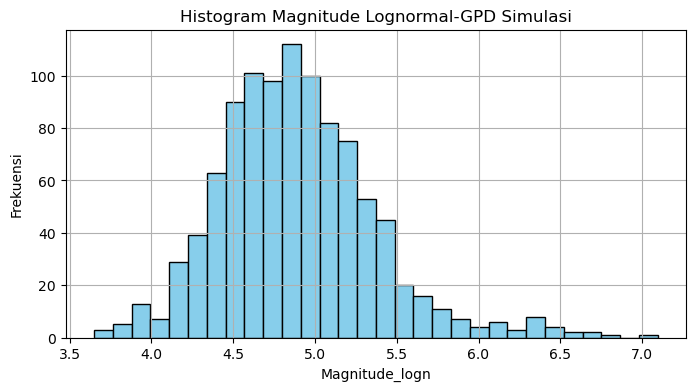

In [11]:
# 1. Generate uniform random numbers
u_rand = np.random.uniform(0, 1, n)

# 2. Inverse transform sampling untuk lognormal-GPD
def logn_gpd_ppf(p, mu, sigma_logn, xi, sigma_gpd, u):
    # Hitung proporsi lognormal
    p_logn = norm.cdf((np.log(u) - mu) / sigma_logn)
    x = np.zeros_like(p)
    # Bagian lognormal
    mask_logn = p < p_logn
    x[mask_logn] = np.exp(norm.ppf(p[mask_logn], loc=mu, scale=sigma_logn))
    # Bagian GPD
    mask_gpd = ~mask_logn
    p_gpd = (p[mask_gpd] - p_logn) / (1 - p_logn)
    if xi != 0:
        x[mask_gpd] = u + sigma_gpd / xi * (1 - (1 - p_gpd) ** xi)
    else:
        x[mask_gpd] = u - sigma_gpd * np.log(1 - p_gpd)
    return x

# 3. Generate magnitude
simulasi['Magnitude_logn'] = logn_gpd_ppf(
    u_rand, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u
)

# 4. Hitung Event Rate
cdf_plus = logn_comp_cdf(simulasi['Magnitude_logn'] + e, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)
cdf_minus = logn_comp_cdf(simulasi['Magnitude_logn'] - e, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)
simulasi['Event Rate_logn'] = (cdf_plus - cdf_minus) / 124

# --- Visualisasi ---
# Scatter mapbox warna = Magnitude_logn
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    color="Magnitude_logn",
    color_continuous_scale="Turbo",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik & Magnitude (warna = magnitude)",
    mapbox_style="open-street-map"
)
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)"
    )
)
fig.show()

# Histogram magnitude
plt.figure(figsize=(8,4))
plt.hist(simulasi['Magnitude_logn'], bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Magnitude_logn')
plt.ylabel('Frekuensi')
plt.title('Histogram Magnitude Lognormal-GPD Simulasi')
plt.grid(True)
plt.show()

In [12]:
simulasi

,Longitude,Latitude,Jarak_epi,Jarak,Kedalaman (km),Magnitude_logn,Event Rate_logn
0,104.715263,-6.750416,131.527687,131.525352,40.158670,3.987947,1.569040e-08
1,106.839211,-7.726504,152.092553,152.088941,46.437357,5.118083,1.193018e-07
2,106.260560,-8.081519,86.391374,86.390712,26.377699,4.825891,1.464752e-07
3,104.514332,-7.691937,29.476230,29.476203,8.999977,4.212239,4.687048e-08
4,105.845325,-7.515990,118.666463,118.664748,36.231939,5.619393,3.618703e-08
...,...,...,...,...,...,...,...
995,105.253562,-8.080390,31.960583,31.960549,9.758523,4.749129,1.439875e-07
996,104.902283,-7.164803,101.551952,101.550877,31.006556,6.457474,2.992964e-09
997,106.217888,-7.345181,155.390021,155.386169,47.444100,5.063235,1.278410e-07
998,105.315813,-7.067831,133.370232,133.367797,40.721225,4.944555,1.416158e-07


## Normal-GPD

In [13]:
def log_likelihood_normal_gpd(params, data, u):
    mu, sigma, xi, sigma_gpd = params
    if sigma <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Normal part
    ll_norm = np.sum(
        -np.log(sigma * np.sqrt(2 * np.pi)) - ((below_u - mu) ** 2) / (2 * sigma ** 2)
    )
    
    # CDF normal di u
    norm_cdf_u = 0.5 * (1 + erf((u - mu) / (sigma * np.sqrt(2))))
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - norm_cdf_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - norm_cdf_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_norm + ll_gpd)  # negative for minimization

def estimate_normal_gpd(data, u):
    mu0 = np.mean(data[data < u])
    sigma0 = np.std(data[data < u])
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (None, None),      # mu (lokasi)
        (1e-6, None),      # sigma (skala)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_normal_gpd,
        x0=[mu0, sigma0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    mu, sigma, xi, sigma_gpd = result.x
    print("Estimasi Parameter Normal-GPD")
    print("Parameter Normal:")
    print(f"\\mu (lokasi) = {mu:.4f}")
    print(f"\\sigma (skala) = {sigma:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return mu, sigma, xi, sigma_gpd

def normal_comp_cdf(x, mu, sigma, xi, sigma_gpd, u):
    # CDF komposit Normal-GPD
    norm_cdf = 0.5 * (1 + erf((np.minimum(x, u) - mu) / (sigma * np.sqrt(2))))
    if np.isscalar(x):
        if x < u:
            return norm_cdf
        else:
            cdf_u = 0.5 * (1 + erf((u - mu) / (sigma * np.sqrt(2))))
            if xi != 0:
                cdf_gpd = 1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf_u = 0.5 * (1 + erf((u - mu) / (sigma * np.sqrt(2))))
        cdf = np.where(
            x < u,
            norm_cdf,
            np.where(
                xi != 0,
                1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

In [14]:
mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd = estimate_normal_gpd(data['mag'].values, u)

Estimasi Parameter Normal-GPD
Parameter Normal:
\mu (lokasi) = 4.8861
\sigma (skala) = 0.4458
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.1725
\sigma (skala) = 0.4426


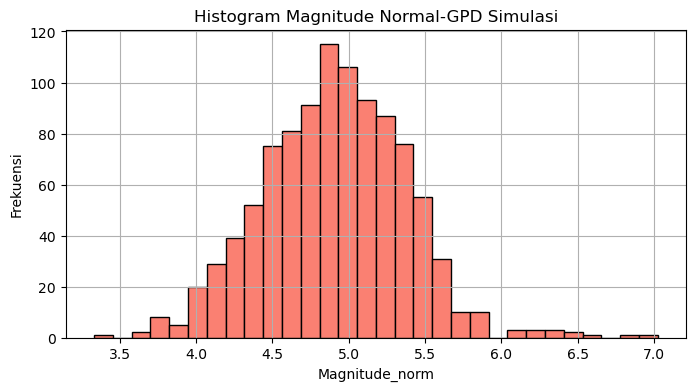

In [15]:
# 1. Generate uniform random numbers
u_rand = np.random.uniform(0, 1, n)

# 2. Inverse transform sampling untuk Normal-GPD
def normal_gpd_ppf(p, mu, sigma, xi, sigma_gpd, u):
    # Hitung proporsi normal
    from scipy.stats import norm
    p_norm = 0.5 * (1 + erf((u - mu) / (sigma * np.sqrt(2))))
    x = np.zeros_like(p)
    # Bagian normal
    mask_norm = p < p_norm
    x[mask_norm] = norm.ppf(p[mask_norm], loc=mu, scale=sigma)
    # Bagian GPD
    mask_gpd = ~mask_norm
    p_gpd = (p[mask_gpd] - p_norm) / (1 - p_norm)
    if xi != 0:
        x[mask_gpd] = u + sigma_gpd / xi * (1 - (1 - p_gpd) ** xi)
    else:
        x[mask_gpd] = u - sigma_gpd * np.log(1 - p_gpd)
    return x

# 3. Generate magnitude
simulasi['Magnitude_norm'] = normal_gpd_ppf(
    u_rand, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u
)

# 4. Hitung Event Rate
cdf_plus = normal_comp_cdf(simulasi['Magnitude_norm'] + e, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u)
cdf_minus = normal_comp_cdf(simulasi['Magnitude_norm'] - e, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u)
simulasi['Event Rate_norm'] = (cdf_plus - cdf_minus) / 124

# --- Visualisasi ---
# Scatter mapbox warna = Magnitude_norm
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    color="Magnitude_norm",
    color_continuous_scale="Turbo",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik & Magnitude Normal-GPD (warna = magnitude)",
    mapbox_style="open-street-map"
)
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)"
    )
)
fig.show()

# Histogram magnitude
plt.figure(figsize=(8,4))
plt.hist(simulasi['Magnitude_norm'], bins=30, color='salmon', edgecolor='k')
plt.xlabel('Magnitude_norm')
plt.ylabel('Frekuensi')
plt.title('Histogram Magnitude Normal-GPD Simulasi')
plt.grid(True)
plt.show()

In [16]:
simulasi

,Longitude,Latitude,Jarak_epi,Jarak,Kedalaman (km),Magnitude_logn,Event Rate_logn,Magnitude_norm,Event Rate_norm
0,104.715263,-6.750416,131.527687,131.525352,40.158670,3.987947,1.569040e-08,5.094406,1.294087e-07
1,106.839211,-7.726504,152.092553,152.088941,46.437357,5.118083,1.193018e-07,5.256801,1.021422e-07
2,106.260560,-8.081519,86.391374,86.390712,26.377699,4.825891,1.464752e-07,5.033162,1.366943e-07
3,104.514332,-7.691937,29.476230,29.476203,8.999977,4.212239,4.687048e-08,5.441580,6.640263e-08
4,105.845325,-7.515990,118.666463,118.664748,36.231939,5.619393,3.618703e-08,4.469832,9.334308e-08
...,...,...,...,...,...,...,...,...,...
995,105.253562,-8.080390,31.960583,31.960549,9.758523,4.749129,1.439875e-07,4.848429,1.438291e-07
996,104.902283,-7.164803,101.551952,101.550877,31.006556,6.457474,2.992964e-09,4.928275,1.436969e-07
997,106.217888,-7.345181,155.390021,155.386169,47.444100,5.063235,1.278410e-07,4.391868,7.807659e-08
998,105.315813,-7.067831,133.370232,133.367797,40.721225,4.944555,1.416158e-07,5.403957,7.350464e-08


# B-value dan Grafik

In [17]:
# --- Fungsi untuk GR fit dan summary ---
def gr_fit(mags):
    bin_width = 0.1
    bins = np.arange(mags.min(), mags.max() + bin_width, bin_width)
    hist, edges = np.histogram(mags, bins=bins)
    cum_hist = np.cumsum(hist[::-1])[::-1]
    log_cum_hist = np.log10(cum_hist[cum_hist > 0])
    mags_fit = edges[:-1][cum_hist > 0]
    slope, intercept, r_value, _, _ = linregress(mags_fit, log_cum_hist)
    return slope, intercept, r_value, mags_fit, log_cum_hist, bins

def get_Mc(mags):
    bin_width = 0.1
    bins = np.arange(mags.min(), mags.max() + bin_width, bin_width)
    hist, bin_edges = np.histogram(mags, bins=bins)
    Mc_index = np.argmax(hist)
    Mc = bin_edges[Mc_index]
    return Mc

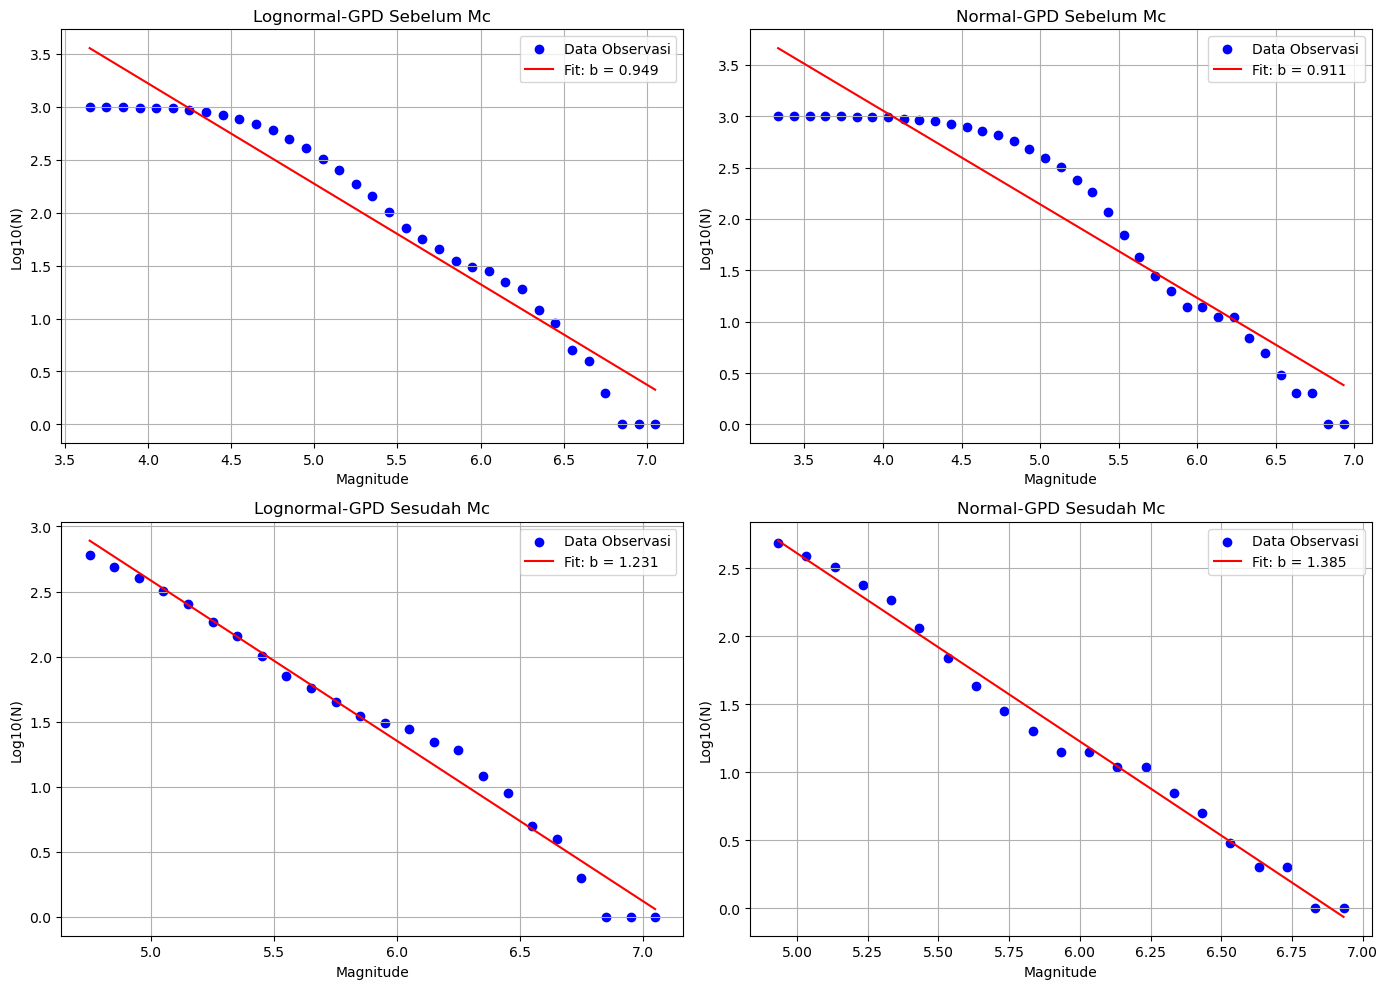

           Model        Mc   a-value   b-value       R^2
0  Lognormal-GPD  4.749447  7.018946  0.949121  0.935503
1     Normal-GPD  4.932251  6.699066  0.911193  0.897658


In [18]:
# --- Proses untuk kedua model ---
results = []
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, (model, col) in enumerate([('Lognormal-GPD', 'Magnitude_logn'), ('Normal-GPD', 'Magnitude_norm')]):
    mags = simulasi[col].values

    # Sebelum Mc
    slope1, intercept1, r1, mags_fit1, log_cum_hist1, bins1 = gr_fit(mags)
    Mc = get_Mc(mags)
    # Sesudah Mc
    mags_after_Mc = mags[mags >= Mc]
    slope2, intercept2, r2, mags_fit2, log_cum_hist2, bins2 = gr_fit(mags_after_Mc)

    # Simpan ke tabel (hanya nilai sebelum Mc)
    results.append({
        'Model': model,
        'Mc': Mc,
        'a-value': intercept1,
        'b-value': -slope1,
        'R^2': r1**2
    })

    # Plot sebelum Mc
    ax = axs[0, i]
    ax.scatter(mags_fit1, log_cum_hist1, label='Data Observasi', color='blue')
    ax.plot(mags_fit1, slope1 * mags_fit1 + intercept1, label=f'Fit: b = {-slope1:.3f}', color='red')
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Log10(N)')
    ax.set_title(f'{model} Sebelum Mc')
    ax.legend()
    ax.grid(True)

    # Plot sesudah Mc
    ax = axs[1, i]
    ax.scatter(mags_fit2, log_cum_hist2, label='Data Observasi', color='blue')
    ax.plot(mags_fit2, slope2 * mags_fit2 + intercept2, label=f'Fit: b = {-slope2:.3f}', color='red')
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Log10(N)')
    ax.set_title(f'{model} Sesudah Mc')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- Tabel hasil ---
results_df = pd.DataFrame(results)
print(results_df)

# Running More Than 1 Times

In [19]:
# --- Sintaks untuk menjalankan Cell 4-27 sebanyak m kali dan merekap b-value setiap simulasi ---
bvalue_results = []

for sim in range(1, m+1):
    # --- Cell 4-27: Generate lokasi, kedalaman, magnitude, dst ---
    # Lokasi
    simulasi = monte_carlo_polygon(boundaries, n, polygon_path)
    simulasi = pd.DataFrame(simulasi, columns=['Longitude', 'Latitude'])

    # Kedalaman
    simulasi[['x', 'y', 'z']] = simulasi.apply(lambda row: pd.Series(longlat_to_xyz(row['Longitude'], row['Latitude'])), axis=1)
    bound = pd.DataFrame(batas.iloc[[0, 3]][['longitude', 'latitude']].values, columns=['longitude', 'latitude'])
    bound[['x', 'y', 'z']] = bound.apply(lambda row: pd.Series(longlat_to_xyz(row['longitude'], row['latitude'])), axis=1)
    a, b = bound.iloc[0][['x', 'y', 'z']].values, bound.iloc[1][['x', 'y', 'z']].values
    q_points = simulasi.apply(lambda row: project_point_to_line(row[['x', 'y', 'z']].values, a, b), axis=1)
    q_longlats = pd.DataFrame([xyz_to_longlat(*q) for q in q_points], columns=['q_lon', 'q_lat'])
    simulasi[['q_lon', 'q_lat']] = q_longlats
    simulasi['Jarak_epi'] = simulasi.apply(lambda row: haversine(row['Latitude'], row['Longitude'], row['q_lat'], row['q_lon']), axis=1)
    simulasi['Jarak'] = 2 * R * np.sin(simulasi['Jarak_epi'] / (2 * R))
    simulasi['Kedalaman (km)'] = simulasi['Jarak'] * np.tan(theta)
    simulasi.drop(columns=['x', 'y', 'z', 'q_lon', 'q_lat'], inplace=True)

    # Magnitude Lognormal-GPD
    u_rand = np.random.uniform(0, 1, n)
    simulasi['Magnitude_logn'] = logn_gpd_ppf(u_rand, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)

    # Magnitude Normal-GPD
    u_rand2 = np.random.uniform(0, 1, n)
    simulasi['Magnitude_norm'] = normal_gpd_ppf(u_rand2, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u)

    # --- Hitung b-value sebelum Mc untuk kedua model ---
    def get_bvalue(mags):
        bin_width = 0.1
        bins = np.arange(mags.min(), mags.max() + bin_width, bin_width)
        hist, edges = np.histogram(mags, bins=bins)
        cum_hist = np.cumsum(hist[::-1])[::-1]
        log_cum_hist = np.log10(cum_hist[cum_hist > 0])
        mags_fit = edges[:-1][cum_hist > 0]
        slope, _, _, _, _ = linregress(mags_fit, log_cum_hist)
        return -slope

    bval_logn = get_bvalue(simulasi['Magnitude_logn'].values)
    bval_norm = get_bvalue(simulasi['Magnitude_norm'].values)

    bvalue_results.append({
        f"Simulasi ke-": sim,
        "Lognormal-GPD": bval_logn,
        "Normal-GPD": bval_norm
    })

# Output tabel b-value tiap simulasi
print(f"Simulasi n = {n}")
bvalue_df = pd.DataFrame(bvalue_results)
print(bvalue_df)

Simulasi n = 1000
   Simulasi ke-  Lognormal-GPD  Normal-GPD
0             1       0.969753    0.914589
1             2       0.980446    0.985492
2             3       1.001780    0.787867
3             4       0.966852    0.934120
4             5       0.961045    0.872750
5             6       0.993586    0.930016
6             7       0.996849    0.826700
7             8       0.930601    1.050791
8             9       0.953104    0.963663
9            10       1.034106    0.968438
